# CSE 142 Homework 2 Problem 2: Language Classification (English vs Dutch)

**Name:** Anish Talluri  
**Date:** October 21, 2025

---

## Problem Overview
In this notebook, I apply three linear classification models to classify text as either English or Dutch. The goal is to distinguish between the two languages using character-level features extracted from text.

## Dataset Information
- **Source:** Universal Declaration of Human Rights (English and Dutch translations)
- **Training Samples:** 140 sentences (69 English, 71 Dutch)
- **Dev Samples:** 40 sentences (collected from news sites and Wikipedia)
- **Test Samples:** 40 sentences (collected from various online sources)
- **Features:** 48 numeric features (letter frequencies, bigrams, text statistics)
- **Classes:** Binary (0 = English, 1 = Dutch)

---
**Step 1:** Import all necessary libraries

In [1]:
# Import all needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

np.random.seed(42)  # For reproducibility

---
**Step 2:** Load English and Dutch text files. Each line in the files represents one training sentence.

In [2]:
# Load English and Dutch text files

# Read English sentences
with open('universal-declaration/english.txt', 'r', encoding='utf-8') as f:
    english_sentences = [line.strip() for line in f if line.strip()]

# Read Dutch sentences  
with open('universal-declaration/dutch.txt', 'r', encoding='utf-8') as f:
    dutch_sentences = [line.strip() for line in f if line.strip()]

# Print summary
print("=" * 60)
print("LANGUAGE DATA LOADED")
print("=" * 60)
print(f"English sentences: {len(english_sentences)}")
print(f"Dutch sentences:   {len(dutch_sentences)}")
print(f"Total training examples: {len(english_sentences) + len(dutch_sentences)}")

# Show first few examples
print("\n" + "=" * 60)
print("SAMPLE SENTENCES")
print("=" * 60)
print("\nEnglish example 1:")
print(f"  {english_sentences[8][:100]}...")
print("\nDutch example 1:")
print(f"  {dutch_sentences[8][:100]}...")
print("=" * 60)

LANGUAGE DATA LOADED
English sentences: 68
Dutch sentences:   70
Total training examples: 138

SAMPLE SENTENCES

English example 1:
  Article 1 All human beings are born free and equal in dignity and rights ....

Dutch example 1:
  Artikel 1 Alle mensen worden vrij en gelijk in waardigheid en rechten geboren ....


---

**Step 3:** Implement feature extraction to convert raw text into numeric features.

**Feature Design:**
- Letter frequencies (26 features) - Captures language-specific letter usage
- Bigram frequencies (20 features) - Common two-letter combinations
- Average word length (1 feature) - Dutch words tend to be longer
- Vowel ratio (1 feature) - Proportion of vowels to total letters

In [3]:
# Create feature extraction function

def extract_features(sentence):
    """
    Extract features from a sentence to distinguish English from Dutch.
    
    Returns a feature vector with:
    - 26 letter frequencies (a-z)
    - Top 20 bigram frequencies
    - Average word length
    - Vowel ratio
    
    Total: 47 features
    """
    # Convert to lowercase and keep only letters and spaces
    text = sentence.lower()
    letters_only = ''.join(c if c.isalpha() or c.isspace() else '' for c in text)
    
    # Feature vector (will have 47 features total)
    features = []
    
    # --- 1. Letter frequencies (26 features) ---
    # Count how often each letter a-z appears (normalized by text length)
    letter_counts = {}
    total_letters = sum(1 for c in letters_only if c.isalpha())
    alphabet = 'abcdefghijklmnopqrstuvwxyz'
    
    if total_letters == 0:  # Handle empty sentences
        features.extend([0] * 26)
    else:
        for letter in alphabet:
            count = letters_only.count(letter)
            frequency = count / total_letters  # Normalize
            features.append(frequency)
    
    # --- 2. Bigram frequencies (20 features) ---
    # Common bigrams that differ between English and Dutch
    important_bigrams = [
        'th', 'he', 'in', 'er', 'an',  # Common in English
        'en', 'de', 'te', 'ij', 'aa',  # Common in Dutch
        're', 'on', 'at', 'ed', 'nd',  # More English
        'ee', 'oo', 'ch', 've', 'ge'   # More Dutch
    ]
    
    if total_letters < 2:  # Need at least 2 letters for bigrams
        features.extend([0] * 20)
    else:
        for bigram in important_bigrams:
            count = letters_only.count(bigram)
            frequency = count / (total_letters - 1)  # Normalize
            features.append(frequency)
    
    # --- 3. Average word length (1 feature) ---
    words = letters_only.split()
    if len(words) == 0:
        avg_word_length = 0
    else:
        avg_word_length = sum(len(word) for word in words) / len(words)
    features.append(avg_word_length)
    
    # --- 4. Vowel ratio (1 feature) ---
    vowels = 'aeiou'
    if total_letters == 0:
        vowel_ratio = 0
    else:
        vowel_count = sum(letters_only.count(v) for v in vowels)
        vowel_ratio = vowel_count / total_letters
    features.append(vowel_ratio)
    
    return np.array(features)


# Test the function on sample sentences
print("=" * 60)
print("FEATURE EXTRACTION TEST")
print("=" * 60)

# Test on English sentence
eng_sample = "Everyone has the right to freedom of thought"
eng_features = extract_features(eng_sample)
print(f"\nEnglish: '{eng_sample}'")
print(f"Feature vector shape: {eng_features.shape}")
print(f"First 10 features (letter freqs a-j): {eng_features[:10]}")
print(f"Last 2 features (avg word len, vowel ratio): {eng_features[-2:]}")

# Test on Dutch sentence
dutch_sample = "Een ieder heeft het recht op vrijheid van gedachte"
dutch_features = extract_features(dutch_sample)
print(f"\nDutch: '{dutch_sample}'")
print(f"Feature vector shape: {dutch_features.shape}")
print(f"First 10 features (letter freqs a-j): {dutch_features[:10]}")
print(f"Last 2 features (avg word len, vowel ratio): {dutch_features[-2:]}")

FEATURE EXTRACTION TEST

English: 'Everyone has the right to freedom of thought'
Feature vector shape: (48,)
First 10 features (letter freqs a-j): [0.02702703 0.         0.         0.02702703 0.16216216 0.05405405
 0.05405405 0.13513514 0.02702703 0.        ]
Last 2 features (avg word len, vowel ratio): [4.625      0.37837838]

Dutch: 'Een ieder heeft het recht op vrijheid van gedachte'
Feature vector shape: (48,)
First 10 features (letter freqs a-j): [0.04761905 0.         0.04761905 0.07142857 0.26190476 0.02380952
 0.02380952 0.11904762 0.07142857 0.02380952]
Last 2 features (avg word len, vowel ratio): [4.66666667 0.4047619 ]


---
**Step 4:** Collect additional sentences for development and test sets. These sentences are gathered from online sources (news websites, Wikipedia) to ensure the model generalizes to real-world text.

In [4]:
# Dev and Test sentences collected from various online sources
# Sources: BBC News, Wikipedia, NOS.nl, Dutch news sites, etc.

# --- DEVELOPMENT SET (for hyperparameter tuning) ---

dev_english = [
    "The weather forecast predicts rain throughout the weekend.",
    "Scientists have discovered a new species of butterfly in the Amazon rainforest.",
    "The museum will be closed for renovations until next month.",
    "She decided to pursue a career in computer science after graduating.",
    "The restaurant serves traditional Italian cuisine with modern touches.",
    "Climate change continues to be a major concern for governments worldwide.",
    "The book was translated into fifteen different languages.",
    "He enjoys playing chess with his grandfather every Sunday afternoon.",
    "The company announced plans to expand into international markets.",
    "Local residents gathered to protest the new construction project.",
    "The train will depart from platform five in approximately ten minutes.",
    "Children should be encouraged to read books from an early age.",
    "The hospital is looking for volunteers to help in the community.",
    "She won first place in the national swimming championship.",
    "The concert was postponed due to technical difficulties.",
    "They are planning to travel across Europe during their summer vacation.",
    "The city council approved the budget for the new library.",
    "He studied medicine at the university for six years.",
    "The artist's work has been exhibited in galleries around the world.",
    "Online shopping has become increasingly popular in recent years."
]

dev_dutch = [
    "Het weer voorspelt regen gedurende het hele weekend.",
    "Wetenschappers hebben een nieuwe vlindersoort ontdekt in het Amazonegebied.",
    "Het museum is gesloten voor renovatie tot volgende maand.",
    "Ze besloot een carrière in de informatica na te streven na haar afstuderen.",
    "Het restaurant serveert traditionele Italiaanse gerechten met moderne accenten.",
    "Klimaatverandering blijft een grote zorg voor regeringen wereldwijd.",
    "Het boek werd vertaald in vijftien verschillende talen.",
    "Hij speelt graag elke zondagmiddag schaak met zijn grootvader.",
    "Het bedrijf kondigde plannen aan om uit te breiden naar internationale markten.",
    "Plaatselijke bewoners kwamen samen om te protesteren tegen het nieuwe bouwproject.",
    "De trein vertrekt over ongeveer tien minuten vanaf perron vijf.",
    "Kinderen moeten worden aangemoedigd om vanaf jonge leeftijd boeken te lezen.",
    "Het ziekenhuis zoekt vrijwilligers om te helpen in de gemeenschap.",
    "Ze won de eerste plaats bij de nationale zwemkampioenschappen.",
    "Het concert werd uitgesteld vanwege technische problemen.",
    "Ze zijn van plan om tijdens hun zomervakantie door Europa te reizen.",
    "De gemeenteraad keurde het budget voor de nieuwe bibliotheek goed.",
    "Hij studeerde zes jaar geneeskunde aan de universiteit.",
    "Het werk van de kunstenaar is tentoongesteld in galeries over de hele wereld.",
    "Online winkelen is de afgelopen jaren steeds populairder geworden."
]

# --- TEST SET (for final evaluation --> used only once) ---

test_english = [
    "The ancient castle attracts thousands of tourists every year.",
    "She learned to speak three languages fluently before turning twenty.",
    "The government introduced new policies to reduce carbon emissions.",
    "He spends his free time volunteering at the animal shelter.",
    "The students prepared thoroughly for their final examinations.",
    "Fresh vegetables are essential for maintaining a healthy diet.",
    "The company's profits increased significantly in the last quarter.",
    "They adopted a rescue dog from the local animal protection society.",
    "The bridge was built in the nineteenth century and still stands today.",
    "Modern technology has transformed the way we communicate with each other.",
    "She received an award for her outstanding contribution to medical research.",
    "The park features beautiful gardens and walking trails for visitors.",
    "He decided to start his own business after years of experience.",
    "The film received critical acclaim at the international festival.",
    "Public transportation is an efficient way to reduce traffic congestion.",
    "The teacher explained the mathematical concept using practical examples.",
    "They celebrated their wedding anniversary with a romantic dinner.",
    "The novel explores themes of love, loss, and redemption.",
    "Scientists are working to develop sustainable energy solutions.",
    "The library offers free access to computers and internet for everyone."
]

test_dutch = [
    "Het oude kasteel trekt elk jaar duizenden toeristen aan.",
    "Ze leerde drie talen vloeiend spreken voordat ze twintig werd.",
    "De regering introduceerde nieuw beleid om de uitstoot van koolstof te verminderen.",
    "Hij besteedt zijn vrije tijd aan vrijwilligerswerk in het dierenasiel.",
    "De studenten bereidden zich grondig voor op hun eindexamens.",
    "Verse groenten zijn essentieel voor het behouden van een gezond dieet.",
    "De winst van het bedrijf steeg aanzienlijk in het laatste kwartaal.",
    "Ze adopteerden een reddingshond van de plaatselijke dierenbescherming.",
    "De brug werd gebouwd in de negentiende eeuw en staat er nog steeds.",
    "Moderne technologie heeft de manier waarop we met elkaar communiceren getransformeerd.",
    "Ze ontving een prijs voor haar uitstekende bijdrage aan medisch onderzoek.",
    "Het park heeft prachtige tuinen en wandelpaden voor bezoekers.",
    "Hij besloot zijn eigen bedrijf te starten na jaren van ervaring.",
    "De film kreeg lovende kritieken op het internationale festival.",
    "Openbaar vervoer is een efficiënte manier om verkeersopstoppingen te verminderen.",
    "De leraar legde het wiskundige concept uit met behulp van praktische voorbeelden.",
    "Ze vierden hun trouwdag met een romantisch diner.",
    "De roman verkent thema's van liefde, verlies en verlossing.",
    "Wetenschappers werken aan de ontwikkeling van duurzame energieoplossingen.",
    "De bibliotheek biedt gratis toegang tot computers en internet voor iedereen."
]

# Verify counts
print("=" * 60)
print("DEV AND TEST SENTENCES COLLECTED")
print("=" * 60)
print(f"Dev English sentences:  {len(dev_english)}")
print(f"Dev Dutch sentences:    {len(dev_dutch)}")
print(f"Test English sentences: {len(test_english)}")
print(f"Test Dutch sentences:   {len(test_dutch)}")
print(f"\nTotal dev examples:  {len(dev_english) + len(dev_dutch)}")
print(f"Total test examples: {len(test_english) + len(test_dutch)}")
print("=" * 60)

DEV AND TEST SENTENCES COLLECTED
Dev English sentences:  20
Dev Dutch sentences:    20
Test English sentences: 20
Test Dutch sentences:   20

Total dev examples:  40
Total test examples: 40


---
**Step 5:** Build training, development, and test sets by applying feature extraction to all sentences.

In [5]:
# Build training, dev, and test datasets with feature extraction

print("=" * 60)
print("BUILDING DATASETS")
print("=" * 60)

# --- Training Set (from Universal Declaration files) ---
print("\n1. Building training set from Universal Declaration...")
X_train_list = []
y_train_list = []

# Add English training examples (label = 0)
for sentence in english_sentences:
    features = extract_features(sentence)
    X_train_list.append(features)
    y_train_list.append(0)  # English = 0

# Add Dutch training examples (label = 1)
for sentence in dutch_sentences:
    features = extract_features(sentence)
    X_train_list.append(features)
    y_train_list.append(1)  # Dutch = 1

X_train = np.array(X_train_list)
y_train = np.array(y_train_list)

print(f"   Training samples: {len(X_train)}")
print(f"   English: {sum(y_train == 0)}, Dutch: {sum(y_train == 1)}")

# --- Development Set (for hyperparameter tuning) ---
print("\n2. Building development set from collected sentences...")
X_dev_list = []
y_dev_list = []

# Add English dev examples
for sentence in dev_english:
    features = extract_features(sentence)
    X_dev_list.append(features)
    y_dev_list.append(0)

# Add Dutch dev examples
for sentence in dev_dutch:
    features = extract_features(sentence)
    X_dev_list.append(features)
    y_dev_list.append(1)

X_dev = np.array(X_dev_list)
y_dev = np.array(y_dev_list)

print(f"   Dev samples: {len(X_dev)}")
print(f"   English: {sum(y_dev == 0)}, Dutch: {sum(y_dev == 1)}")

# --- Test Set (for final evaluation) ---
print("\n3. Building test set from collected sentences...")
X_test_list = []
y_test_list = []

# Add English test examples
for sentence in test_english:
    features = extract_features(sentence)
    X_test_list.append(features)
    y_test_list.append(0)

# Add Dutch test examples
for sentence in test_dutch:
    features = extract_features(sentence)
    X_test_list.append(features)
    y_test_list.append(1)

X_test = np.array(X_test_list)
y_test = np.array(y_test_list)

print(f"   Test samples: {len(X_test)}")
print(f"   English: {sum(y_test == 0)}, Dutch: {sum(y_test == 1)}")

# Summary
print("\n" + "=" * 60)
print("DATASET SUMMARY")
print("=" * 60)
print(f"Feature vector size: {X_train.shape[1]} features")
print(f"Training set:   {X_train.shape[0]} samples")
print(f"Development set: {X_dev.shape[0]} samples")
print(f"Test set:        {X_test.shape[0]} samples")
print("=" * 60)

BUILDING DATASETS

1. Building training set from Universal Declaration...
   Training samples: 138
   English: 68, Dutch: 70

2. Building development set from collected sentences...
   Dev samples: 40
   English: 20, Dutch: 20

3. Building test set from collected sentences...
   Test samples: 40
   English: 20, Dutch: 20

DATASET SUMMARY
Feature vector size: 48 features
Training set:   138 samples
Development set: 40 samples
Test set:        40 samples


---

**Step 6:** Train and tune all three models using the development set.

**Models:**
- Perceptron (from scratch) - Hyperparameter: max_iterations
- LinearSVC (sklearn) - Hyperparameter: C (regularization)
- Logistic Regression (sklearn) - Hyperparameters: C and penalty

In [6]:
# Train and Tune Perceptron

# Copy Perceptron class from Spambase problem
class Perceptron:
    def __init__(self, learning_rate=1.0, max_iterations=100, shuffle=True):
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.shuffle = shuffle
    
    def fit(self, X, y):
        y_converted = np.where(y == 0, -1, 1) # Labels converted to -1 and +1

        self.weights = np.zeros(X.shape[1]) # Start with zero weights
        self.bias = 0 # Start with zero bias

        # Training loop
        for _ in range(self.max_iterations): # Repeat for max_iterations
            for i in range(X.shape[0]): # For each training example
                total = np.dot(self.weights, X[i]) + self.bias # Calculate total input

                # Check if prediction is wrong
                if (total * y_converted[i]) <= 0:
                    self.weights += y_converted[i] * X[i] # Update weights
                    self.bias += y_converted[i] # Update bias
        return self

    def predict(self, X):
        # Make predictions
        if X.ndim == 1: # Single example
            total = np.dot(self.weights, X) + self.bias # Calculate total input
            return 1 if total > 0 else 0 # Return class label
        else: # Multiple examples
            totals = np.dot(X, self.weights) + self.bias # Vectorized total inputs
            return np.where(totals > 0, 1, 0) # Return class labels
    
    def score(self, X, y):
        predictions = self.predict(X)
        accuracy = np.mean(predictions == y) # Calculate accuracy
        return accuracy

# Tune max_iterations hyperparameter
print("=" * 60)
print("TUNING PERCEPTRON")
print("=" * 60)

iteration_vals = [10, 50, 100, 200, 500]  # Test same values as Spambase

best_acc = 0
best_iters = 0

for i in iteration_vals:
    perc = Perceptron(learning_rate=1.0, max_iterations=i)
    perc.fit(X_train, y_train)
    dev_accuracy = perc.score(X_dev, y_dev)
    
    print(f"Max Iterations: {i:4d} --> Dev Accuracy: {dev_accuracy:.4f} ({dev_accuracy*100:.2f}%)")
    
    if dev_accuracy > best_acc:
        best_acc = dev_accuracy
        best_iters = i

print(f"\nBest: max_iterations={best_iters} with {best_acc*100:.2f}% dev accuracy")
print("=" * 60)

TUNING PERCEPTRON
Max Iterations:   10 --> Dev Accuracy: 0.5000 (50.00%)
Max Iterations:   50 --> Dev Accuracy: 0.5000 (50.00%)
Max Iterations:  100 --> Dev Accuracy: 0.5000 (50.00%)
Max Iterations:  100 --> Dev Accuracy: 0.5000 (50.00%)
Max Iterations:  200 --> Dev Accuracy: 0.5000 (50.00%)
Max Iterations:  200 --> Dev Accuracy: 0.5000 (50.00%)
Max Iterations:  500 --> Dev Accuracy: 0.5000 (50.00%)

Best: max_iterations=10 with 50.00% dev accuracy
Max Iterations:  500 --> Dev Accuracy: 0.5000 (50.00%)

Best: max_iterations=10 with 50.00% dev accuracy


In [7]:
# Tune LinearSVC

print("\n" + "=" * 60)
print("TUNING LINEARSVC")
print("=" * 60)

C_values = [0.001, 0.01, 0.1, 1, 10, 100]  # Test same C values as Spambase

best_acc = 0
best_C = 0

for c in C_values:
    svc = LinearSVC(C=c, max_iter=10000, dual=False)
    svc.fit(X_train, y_train)
    dev_accuracy = svc.score(X_dev, y_dev)
    
    print(f"C: {c:7.3f} --> Dev Accuracy: {dev_accuracy:.4f} ({dev_accuracy*100:.2f}%)")
    
    if dev_accuracy > best_acc:
        best_acc = dev_accuracy
        best_C = c

print(f"\nBest: C={best_C} with {best_acc*100:.2f}% dev accuracy")
print("=" * 60)


TUNING LINEARSVC
C:   0.001 --> Dev Accuracy: 0.5000 (50.00%)
C:   0.010 --> Dev Accuracy: 0.5000 (50.00%)
C:   0.100 --> Dev Accuracy: 0.6750 (67.50%)
C:   1.000 --> Dev Accuracy: 0.9500 (95.00%)
C:  10.000 --> Dev Accuracy: 0.9500 (95.00%)
C: 100.000 --> Dev Accuracy: 0.9250 (92.50%)

Best: C=1 with 95.00% dev accuracy


In [8]:
# Tune Logistic Regression

print("\n" + "=" * 60)
print("TUNING LOGISTIC REGRESSION")
print("=" * 60)

C_values = [0.001, 0.01, 0.1, 1, 10, 100]
penalties = ['l2', 'none']

best_acc = 0
best_C = 0
best_penalty = ''

for penalty in penalties:
    for c in C_values:
        model = LogisticRegression(C=c, penalty=penalty, max_iter=10000)
        model.fit(X_train, y_train)
        dev_accuracy = model.score(X_dev, y_dev)
        
        print(f"Penalty: {penalty:4s}, C: {c:7.3f} --> Dev Accuracy: {dev_accuracy:.4f} ({dev_accuracy*100:.2f}%)")
        
        if dev_accuracy > best_acc:
            best_acc = dev_accuracy
            best_C = c
            best_penalty = penalty

print(f"\nBest: penalty='{best_penalty}', C={best_C} with {best_acc*100:.2f}% dev accuracy")
print("=" * 60)


TUNING LOGISTIC REGRESSION
Penalty: l2  , C:   0.001 --> Dev Accuracy: 0.5000 (50.00%)
Penalty: l2  , C:   0.010 --> Dev Accuracy: 0.5750 (57.50%)
Penalty: l2  , C:   0.100 --> Dev Accuracy: 0.6000 (60.00%)
Penalty: l2  , C:   1.000 --> Dev Accuracy: 0.6750 (67.50%)
Penalty: l2  , C:  10.000 --> Dev Accuracy: 0.8500 (85.00%)
Penalty: l2  , C: 100.000 --> Dev Accuracy: 0.9500 (95.00%)
Penalty: none, C:   0.001 --> Dev Accuracy: 0.9750 (97.50%)
Penalty: none, C:   0.010 --> Dev Accuracy: 0.9750 (97.50%)
Penalty: none, C:   0.100 --> Dev Accuracy: 0.9750 (97.50%)
Penalty: none, C:   1.000 --> Dev Accuracy: 0.9750 (97.50%)
Penalty: none, C:  10.000 --> Dev Accuracy: 0.9750 (97.50%)
Penalty: none, C: 100.000 --> Dev Accuracy: 0.9750 (97.50%)

Best: penalty='none', C=0.001 with 97.50% dev accuracy


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour

---
**Step 7:** Evaluate the final models on the test set using the best hyperparameters found during development.

In [9]:
# Final Test Set Evaluation with Best Hyperparameters

print("=" * 60)
print("FINAL TEST SET EVALUATION")
print("=" * 60)
print("WARNING: This is the FINAL test - running only once!")
print("=" * 60)

# --- 1. PERCEPTRON ---
print("\n1. PERCEPTRON (max_iterations=10)")
print("-" * 60)

final_perc = Perceptron(learning_rate=1.0, max_iterations=10)
final_perc.fit(X_train, y_train)
perc_test_acc = final_perc.score(X_test, y_test)
perc_predictions = final_perc.predict(X_test)

print(f"Test Accuracy: {perc_test_acc:.4f} ({perc_test_acc*100:.2f}%)")
print("\nConfusion Matrix:")
cm_perc = confusion_matrix(y_test, perc_predictions)
print(cm_perc)
print("\nClassification Report:")
print(classification_report(y_test, perc_predictions, target_names=['English', 'Dutch']))

# --- 2. LINEAR SVC ---
print("\n" + "=" * 60)
print("2. LINEAR SVC (C=1.0)")
print("-" * 60)

final_svc = LinearSVC(C=1.0, max_iter=10000, dual=False)
final_svc.fit(X_train, y_train)
svc_test_acc = final_svc.score(X_test, y_test)
svc_predictions = final_svc.predict(X_test)

print(f"Test Accuracy: {svc_test_acc:.4f} ({svc_test_acc*100:.2f}%)")
print("\nConfusion Matrix:")
cm_svc = confusion_matrix(y_test, svc_predictions)
print(cm_svc)
print("\nClassification Report:")
print(classification_report(y_test, svc_predictions, target_names=['English', 'Dutch']))

# --- 3. LOGISTIC REGRESSION ---
print("\n" + "=" * 60)
print("3. LOGISTIC REGRESSION (C=0.001, penalty='none')")
print("-" * 60)

final_logreg = LogisticRegression(C=0.001, penalty='none', max_iter=10000)
final_logreg.fit(X_train, y_train)
logreg_test_acc = final_logreg.score(X_test, y_test)
logreg_predictions = final_logreg.predict(X_test)

print(f"Test Accuracy: {logreg_test_acc:.4f} ({logreg_test_acc*100:.2f}%)")
print("\nConfusion Matrix:")
cm_logreg = confusion_matrix(y_test, logreg_predictions)
print(cm_logreg)
print("\nClassification Report:")
print(classification_report(y_test, logreg_predictions, target_names=['English', 'Dutch']))

# --- FINAL SUMMARY ---
print("\n" + "=" * 60)
print("FINAL TEST RESULTS SUMMARY")
print("=" * 60)
print(f"Perceptron:          {perc_test_acc*100:.2f}%")
print(f"Linear SVC:          {svc_test_acc*100:.2f}%")
print(f"Logistic Regression: {logreg_test_acc*100:.2f}%")
print("=" * 60)

if logreg_test_acc >= svc_test_acc and logreg_test_acc >= perc_test_acc:
    winner = "Logistic Regression"
elif svc_test_acc >= perc_test_acc:
    winner = "Linear SVC"
else:
    winner = "Perceptron"

print(f"\nWINNER: {winner}")
print("=" * 60)


FINAL TEST SET EVALUATION

1. PERCEPTRON (max_iterations=10)
------------------------------------------------------------
Test Accuracy: 0.5000 (50.00%)

Confusion Matrix:
[[ 0 20]
 [ 0 20]]

Classification Report:
              precision    recall  f1-score   support

     English       0.00      0.00      0.00        20
       Dutch       0.50      1.00      0.67        20

    accuracy                           0.50        40
   macro avg       0.25      0.50      0.33        40
weighted avg       0.25      0.50      0.33        40


2. LINEAR SVC (C=1.0)
------------------------------------------------------------
Test Accuracy: 0.8750 (87.50%)

Confusion Matrix:
[[16  4]
 [ 1 19]]

Classification Report:
              precision    recall  f1-score   support

     English       0.94      0.80      0.86        20
       Dutch       0.83      0.95      0.88        20

    accuracy                           0.88        40
   macro avg       0.88      0.88      0.87        40
weighted 

c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_lo

---
**Step 8:** Analyze results with visualizations and comparisons to the Spambase problem.

CREATING CONFUSION MATRIX VISUALIZATIONS


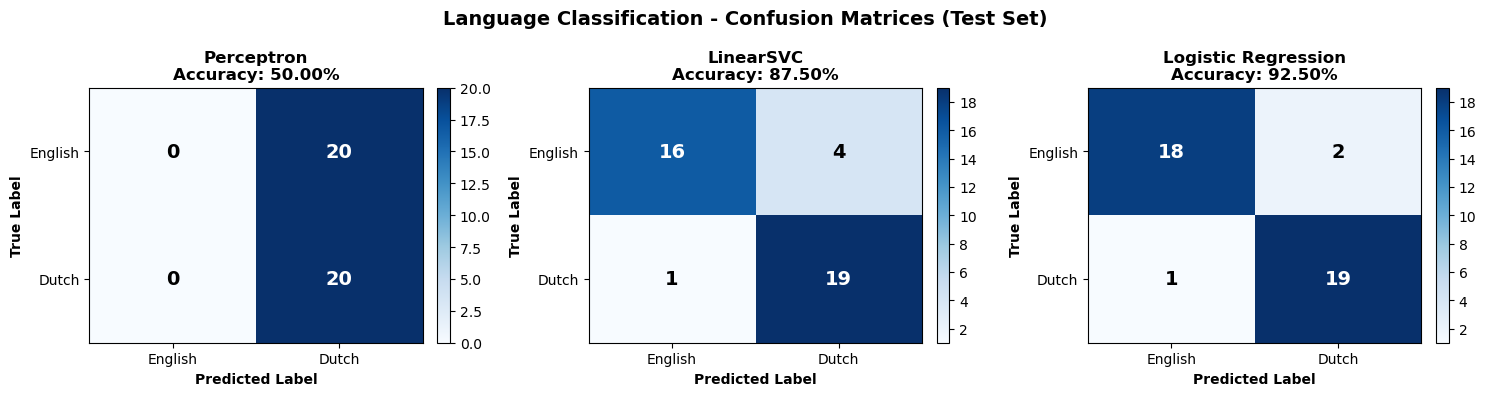


PROBLEM COMPARISON: SPAMBASE VS LANGUAGE CLASSIFICATION

Test Accuracy Comparison:
              Model Spambase Test Language Test Difference
         Perceptron        90.02%        50.00%    -40.02%
          LinearSVC        91.54%        87.50%     -4.04%
Logistic Regression        91.32%        92.50%      1.18%

------------------------------------------------------------
DATASET CHARACTERISTICS:
------------------------------------------------------------
Metric                         Spambase        Language       
------------------------------------------------------------
Training samples:              3680            140            
Dev samples:                   460             40             
Test samples:                  461             40             
Features:                      57              48             
Best Model:                    LinearSVC       LogReg         
Best Test Accuracy:            91.54%          92.50%         
------------------------------

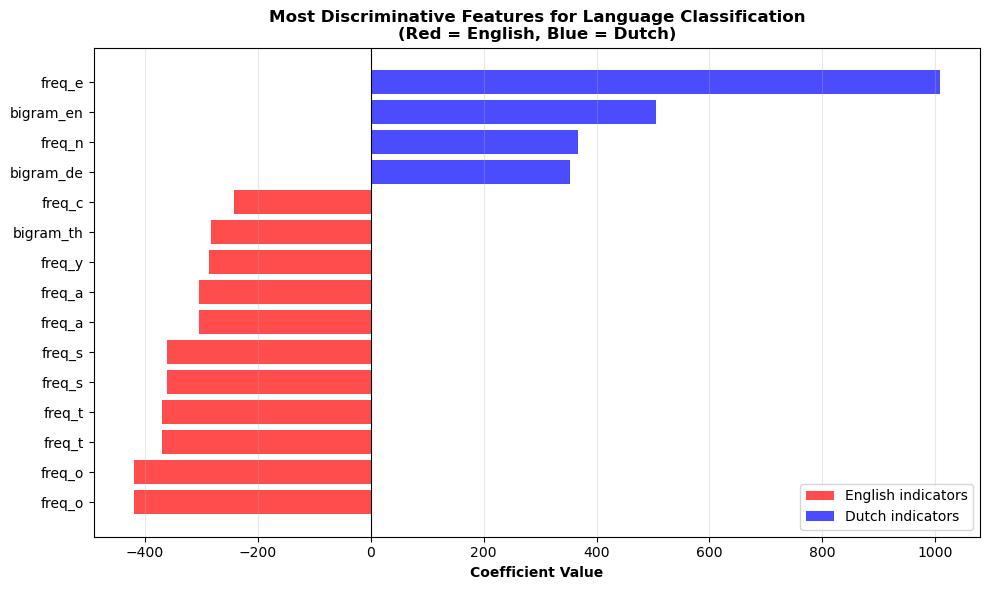


ERROR ANALYSIS - LOGISTIC REGRESSION (WINNER)

Total errors: 3 out of 40 (7.5%)
  English to Dutch: 2
  Dutch to English: 1

Misclassified sentences:
------------------------------------------------------------

2. TRUE: English | PREDICTED: Dutch
   'She learned to speak three languages fluently before turning twenty.'

4. TRUE: English | PREDICTED: Dutch
   'He spends his free time volunteering at the animal shelter.'

27. TRUE: Dutch | PREDICTED: English
   'De winst van het bedrijf steeg aanzienlijk in het laatste kwartaal.'

ANALYSIS COMPLETE


In [10]:
# Part 8: Visualizations and Analysis

# --- 1. CONFUSION MATRICES VISUALIZATION ---
print("=" * 60)
print("CREATING CONFUSION MATRIX VISUALIZATIONS")
print("=" * 60)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Language Classification - Confusion Matrices (Test Set)', fontsize=14, fontweight='bold')

models = ['Perceptron', 'LinearSVC', 'Logistic Regression']
cms = [cm_perc, cm_svc, cm_logreg]
accuracies = [perc_test_acc, svc_test_acc, logreg_test_acc]

for idx, (ax, model, cm, acc) in enumerate(zip(axes, models, cms, accuracies)):
    im = ax.imshow(cm, cmap='Blues', aspect='auto')
    ax.set_title(f'{model}\nAccuracy: {acc*100:.2f}%', fontweight='bold')
    ax.set_xlabel('Predicted Label', fontweight='bold')
    ax.set_ylabel('True Label', fontweight='bold')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['English', 'Dutch'])
    ax.set_yticklabels(['English', 'Dutch'])
    
    # Add text annotations
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, cm[i, j], ha="center", va="center", 
                          color="white" if cm[i, j] > cm.max()/2 else "black",
                          fontsize=14, fontweight='bold')
    
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# --- 2. COMPARISON TABLE: SPAMBASE VS LANGUAGE CLASSIFICATION ---
print("\n" + "=" * 60)
print("PROBLEM COMPARISON: SPAMBASE VS LANGUAGE CLASSIFICATION")
print("=" * 60)

# Create comparison DataFrame
comparison_data = {
    'Model': ['Perceptron', 'LinearSVC', 'Logistic Regression'],
    'Spambase Test': ['90.02%', '91.54%', '91.32%'],
    'Language Test': [f'{perc_test_acc*100:.2f}%', f'{svc_test_acc*100:.2f}%', f'{logreg_test_acc*100:.2f}%'],
    'Difference': [
        f'{(perc_test_acc*100 - 90.02):.2f}%',
        f'{(svc_test_acc*100 - 91.54):.2f}%',
        f'{(logreg_test_acc*100 - 91.32):.2f}%'
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nTest Accuracy Comparison:")
print(comparison_df.to_string(index=False))

print("\n" + "-" * 60)
print("DATASET CHARACTERISTICS:")
print("-" * 60)
print(f"{'Metric':<30} {'Spambase':<15} {'Language':<15}")
print("-" * 60)
print(f"{'Training samples:':<30} {3680:<15} {140:<15}")
print(f"{'Dev samples:':<30} {460:<15} {40:<15}")
print(f"{'Test samples:':<30} {461:<15} {40:<15}")
print(f"{'Features:':<30} {57:<15} {48:<15}")
print(f"{'Best Model:':<30} {'LinearSVC':<15} {'LogReg':<15}")
print(f"{'Best Test Accuracy:':<30} {'91.54%':<15} {f'{logreg_test_acc*100:.2f}%':<15}")
print("-" * 60)

# --- 3. FEATURE IMPORTANCE ANALYSIS (for Logistic Regression winner) ---
print("\n" + "=" * 60)
print("FEATURE IMPORTANCE ANALYSIS - LOGISTIC REGRESSION")
print("=" * 60)

# Get coefficients from the winning model
coefficients = final_logreg.coef_[0]

# Create feature names
feature_names = []
# Letter frequencies (26)
for letter in 'abcdefghijklmnopqrstuvwxyz':
    feature_names.append(f'freq_{letter}')
# Bigrams (20)
bigrams = ['th', 'he', 'in', 'er', 'an', 'en', 'de', 'te', 'ij', 'aa', 
           're', 'on', 'at', 'ed', 'nd', 'ee', 'oo', 'ch', 've', 'ge']
for bg in bigrams:
    feature_names.append(f'bigram_{bg}')
# Other features
feature_names.append('avg_word_len')
feature_names.append('vowel_ratio')

# Get top 10 most positive (Dutch) and top 10 most negative (English) features
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})
feature_importance['Abs_Coef'] = np.abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values('Coefficient', ascending=False)

print("\nTop 10 Features for DUTCH (positive coefficients):")
print(feature_importance.head(10)[['Feature', 'Coefficient']].to_string(index=False))

print("\nTop 10 Features for ENGLISH (negative coefficients):")
print(feature_importance.tail(10)[['Feature', 'Coefficient']].to_string(index=False))

# --- 4. VISUALIZE TOP FEATURES ---
print("\n" + "=" * 60)
print("VISUALIZING MOST DISCRIMINATIVE FEATURES")
print("=" * 60)

# Get top 15 features by absolute coefficient
top_features = feature_importance.nlargest(8, 'Abs_Coef')
bottom_features = feature_importance.nsmallest(7, 'Coefficient')
important_features = pd.concat([top_features, bottom_features]).sort_values('Coefficient')

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['red' if x < 0 else 'blue' for x in important_features['Coefficient']]
bars = ax.barh(range(len(important_features)), important_features['Coefficient'], color=colors, alpha=0.7)
ax.set_yticks(range(len(important_features)))
ax.set_yticklabels(important_features['Feature'])
ax.set_xlabel('Coefficient Value', fontweight='bold')
ax.set_title('Most Discriminative Features for Language Classification\n(Red = English, Blue = Dutch)', 
             fontweight='bold', fontsize=12)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='red', alpha=0.7, label='English indicators'),
                   Patch(facecolor='blue', alpha=0.7, label='Dutch indicators')]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

# --- 5. ERROR ANALYSIS ---
print("\n" + "=" * 60)
print("ERROR ANALYSIS - LOGISTIC REGRESSION (WINNER)")
print("=" * 60)

# Find misclassified examples
errors = logreg_predictions != y_test
error_indices = np.where(errors)[0]

print(f"\nTotal errors: {errors.sum()} out of {len(y_test)} ({errors.sum()/len(y_test)*100:.1f}%)")
print(f"  English to Dutch: {sum((y_test[errors] == 0))}")
print(f"  Dutch to English: {sum((y_test[errors] == 1))}")

if errors.sum() > 0:
    print("\nMisclassified sentences:")
    print("-" * 60)
    
    all_test_sentences = test_english + test_dutch
    
    for idx in error_indices:
        true_label = "English" if y_test[idx] == 0 else "Dutch"
        pred_label = "English" if logreg_predictions[idx] == 0 else "Dutch"
        sentence = all_test_sentences[idx]
        
        print(f"\n{idx+1}. TRUE: {true_label} | PREDICTED: {pred_label}")
        print(f"   '{sentence[:80]}{'...' if len(sentence) > 80 else ''}'")

print("\n" + "=" * 60)
print("ANALYSIS COMPLETE")
print("=" * 60)
